In [1]:
import torch
import numpy as np

import pandas as pd

from torchvision.models import alexnet
from torchvision.transforms import Compose, ToTensor, Resize, Grayscale
from torch.utils.data import DataLoader
from PytorchStorage import ForwardModuleStorage
from sklearn.cluster import KMeans
from tqdm import tqdm_notebook as tqdm
from collections import OrderedDict
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from fastai.vision import *
from fastai.layers import CrossEntropyFlat


In [2]:
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
import matplotlib.pyplot as plt
from matplotlib import offsetbox
%matplotlib notebook


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
TRAIN = False

In [4]:
def pca(x, k=2):
    """
    From http://agnesmustar.com/2017/11/01/principal-component-analysis-pca-implemented-pytorch/
    """
    # preprocess the data
    X_mean = torch.mean(x,0)
    x = x - X_mean.expand_as(x)
    # svd
    U,S,V = torch.svd(torch.t(x))
    return torch.mm(x,U[:,:k])

## Dataset

In [5]:
from torchvision.datasets import MNIST
from fastai.vision import *

tr = Compose([Grayscale(), ToTensor()])

train_ds = MNIST(root='~/Documents/datasets/', download=True, transform=tr)
train_dl = DataLoader(train_ds, num_workers=14, batch_size=128, shuffle=True)

val_ds = MNIST(root='~/Documents/datasets/', train=False, transform=tr)
val_dl = DataLoader(val_ds, num_workers=14, batch_size=128, shuffle=False)

data = ImageDataBunch(train_dl, val_dl)

## Model

In [6]:
model = simple_cnn((1,16,32,64)).to(device)

learn = Learner(data, model, path='./', loss_func=CrossEntropyFlat())
learn.metrics=[accuracy]

### Train

In [7]:
if TRAIN:
    learn.fit(25)
    learn.save('learn', return_path=True)

In [8]:
learn.load('./learn')

learn.validate(metrics=[accuracy])

[0.11849265, tensor(0.9632)]

In [9]:
def tensor2numpy(*args):
    return [e.cpu().numpy() for e in args]

## PCA

In [26]:
from mpl_toolkits.mplot3d import proj3d
from matplotlib import offsetbox

class ImageAnnotations3D():
    """
    From https://stackoverflow.com/questions/48180327/matplotlib-3d-scatter-plot-with-images-as-annotations. Yes matplotlib is shit
    """
    def __init__(self, xyz, imgs, ax3d,ax2d, zoom=1):
        self.xyz = xyz
        self.imgs = imgs
        self.ax3d = ax3d
        self.ax2d = ax2d
        self.zoom = zoom
        self.annot = []
        for s,im in zip(self.xyz, self.imgs):
            x,y = self.proj(s)
            self.annot.append(self.image(im,[x,y]))
        self.lim = self.ax3d.get_w_lims()
        self.rot = self.ax3d.get_proj()
        self.cid = self.ax3d.figure.canvas.mpl_connect("draw_event",self.update)

        self.funcmap = {"button_press_event" : self.ax3d._button_press,
                        "motion_notify_event" : self.ax3d._on_move,
                        "button_release_event" : self.ax3d._button_release}

        self.cfs = [self.ax3d.figure.canvas.mpl_connect(kind, self.cb) \
                        for kind in self.funcmap.keys()]

    def cb(self, event):
        event.inaxes = self.ax3d
        self.funcmap[event.name](event)

    def proj(self, X):
        """ From a 3D point in axes ax1, 
            calculate position in 2D in ax2 """
        x,y,z = X
        x2, y2, _ = proj3d.proj_transform(x,y,z, self.ax3d.get_proj())
        tr = self.ax3d.transData.transform((x2, y2))
        return self.ax2d.transData.inverted().transform(tr)

    def image(self,arr,xy):
        """ Place an image (arr) as annotation at position xy """
        im = offsetbox.OffsetImage(arr, zoom=self.zoom)
        im.image.axes = self.ax3d
        ab = offsetbox.AnnotationBbox(im, xy,
                            xycoords='data', boxcoords="offset points", pad=0.3)
        self.ax2d.add_artist(ab)
        return ab

    def update(self,event):
        if np.any(self.ax3d.get_w_lims() != self.lim) or \
                        np.any(self.ax3d.get_proj() != self.rot):
            self.lim = self.ax3d.get_w_lims()
            self.rot = self.ax3d.get_proj()
            for s,ab in zip(self.xyz, self.annot):
                ab.xy = self.proj(s)


In [28]:
import pandas as pd
from dataclasses import dataclass
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
import matplotlib.pyplot as plt
from matplotlib import offsetbox
import numpy as np
@dataclass
class State():
    points: torch.tensor = torch.empty(0)
    y: torch.tensor = torch.empty(0).long()
    indeces: torch.tensor = torch.empty(0).long()
    
    def __repr__(self):
        return f"points={self.points.shape}"
    
class ModulePCA():
    reducers = ['kmeans']
    """
    Apply and visualize PCA with k-features of a specific CNN-layer. 
    It computes the PCA values batch-wise to reduce memory usage and increase performance.
    """
    def __init__(self, module, layer, dataloader):
        self.module, self.layer = module, layer
        self.storage = ForwardModuleStorage(module, [layer])
        self.dataloader = dataloader
        self.state = State()
      
    def points(self, dataloader, k=2, n_batches=None):
        """
        Batch-wise PCA. It returns the pca points, the labels and the inputs as Pytorch Tensors.
        """
        for i, (x, y) in enumerate(dataloader):
            y, x = y.to(device), x.to(device)
            self.storage(x) # run input into the storage
            with torch.no_grad():
                features = self.storage[self.layer][0]
                flat_features = features.view(features.shape[0], -1)
                pca_features = pca(flat_features, k=k)
                del self.storage.state[self.layer] # reinit storage -> save memory
                self.storage.state[self.layer] = []
                if n_batches is not None and i == n_batches: break
                yield pca_features, y, x
    
    def before_store(self, points, y, x):
        """
        Called before the points, labels are stored into the .state
        """
        return points, y, x
    
    def after_store(self, points, y, x):
        """
        Called after the points, labels are stored into the .state
        """
        return points, y, x

    def __call__(self, *args, **kwargs):
        bar = tqdm(self.points(self.dataloader, *args, **kwargs))
        for points, y, x in bar:
            # store points and labels by bringing them to the cpu to save GPU memory
            points, y, x = self.before_store(points, y, x)
            self.state.points = torch.cat([self.state.points, points.cpu()])
            self.state.y = torch.cat([self.state.y, y.cpu()])
            points, y, x = self.after_store(points, y, x)
            bar.set_description(f"Stored {self.state.points.shape[0]} points")

        self.state.indeces = torch.arange(len(self.state.points))
        return self
    
    def reduce(self, to=100, using='kmeans'):
        """
        Reduce the number of .state.points using different methods.
        """
        if using not in ModulePCA.reducers: raise ValueError(f"Parameter 'using' must be one of {ModulePCA.reducers}")
        points, y, indeces = self.state.points, self.state.y, self.state.indeces
        
        bar = tqdm(total=1)
        bar.set_description(f"Reducing {self.state.points.shape[0]} points to {to} using {using}")
        
        if using == 'kmeans':
            kmeans = KMeans(n_clusters=to)
            kmeans.fit(module_pca.state.points.numpy(), y=module_pca.state.y.numpy())
            points = kmeans.cluster_centers_
            # update labels and indeces using the position of the clusters
            y = [self.state.y.numpy()[np.where(kmeans.labels_ == i)][0] for i in range(kmeans.n_clusters)]
            indeces = [self.state.indeces.numpy()[np.where(kmeans.labels_ == i)][0] for i in range(kmeans.n_clusters)]
        # creates a new ModulePCA with the reduced points
        reduced_module_pca =  ModulePCA(self.module, self.layer, self.dataloader)
        reduced_module_pca.state = State(torch.from_numpy(points), 
                                          torch.from_numpy(np.array(y)),
                                          torch.from_numpy(np.array(indeces)))
        
        bar.update(1)
        
        return reduced_module_pca
    
    def _scatter(self):
        """
        Creates a scatter plot using self.fig, self.ax
        """
        points, y = tensor2numpy(self.state.points, self.state.y)
        for i, label in enumerate(np.unique(y).tolist()):
                if points.shape[-1] == 2:
                    self.ax.scatter(points[y == label, 0], points[y == label, 1], label=label, alpha=0.5)
                elif points.shape[-1] == 3:
                    self.ax.scatter(points[y == label, 0], points[y == label, 1], points[y == label, 2], label=label, alpha=0.5)
    
    def _legend(self):
        """
        Remove duplicates name in the legend
        """
        handles, labels = self.ax.get_legend_handles_labels()
        by_label = OrderedDict(zip(labels, handles))
        self.ax.legend(by_label.values(), by_label.keys())
        
    
    def plot2d(self):
        self.fig,  self.ax  = plt.figure(),  plt.subplot(111)        
        title = f"{len(self.state.points)} points"
        # add subtitle with more info
        
        self._scatter()
        self._legend()

        plt.title(title)
        
        return self
    
    def plot3d(self):
        self.fig = plt.figure()
        self.ax = self.fig.add_subplot(111, projection='3d')
        title = f"{len(self.state.points)} points"        
        self._scatter()
        self._legend()

        plt.title(title)
        
        return self
    
    def _annotate2d(self, zoom=1, transform=None):
        self.fig,  self.ax  = plt.figure(),  plt.subplot(111)    
        self._scatter() 

        for point, i in zip(self.state.points.numpy(), self.state.indeces.numpy()):
            x, y = point[0], point[1]
            img = self.dataloader.dataset[i][0]
            if transform is not None: img = transform(img)
            img_np = img.permute(1,2,0).numpy().squeeze()
            ab = AnnotationBbox(OffsetImage(img_np, zoom=zoom), (x, y), frameon=False)
            self.ax.add_artist(ab)
    
    def _annotate3d(self, zoom=1, transform=None):
        fig = plt.figure()
        ax = fig.add_subplot(111, projection=Axes3D.name, picker=True)
        points = self.state.points.numpy()
        
        imgs = []
        
        for i in self.state.indeces.numpy():
            img = self.dataloader.dataset[i][0]
            if transform is not None: img = transform(img)
            img_np = img.permute(1,2,0).numpy().squeeze()
            imgs.append(img_np)

        x, y, z = points[:,0], points[:,1], points[:,2]
        
        ax.scatter(x, y, z, marker="o")

#         self._scatter()?

        ax2 = fig.add_subplot(111,frame_on=False) 
        ax2.axis("off")
        ax2.axis([0,1,0,1])
        
        ia = ImageAnnotations3D(np.c_[x,y,z],imgs, ax, ax2, zoom=zoom)
        
    def annotate(self, *args, **kwargs):
        if  self.state.points.shape[-1] == 2: self._annotate2d(*args, **kwargs)
        elif  self.state.points.shape[-1] == 3: self._annotate3d(*args, **kwargs)
            
        return self

## 3D

<IPython.core.display.Javascript object>


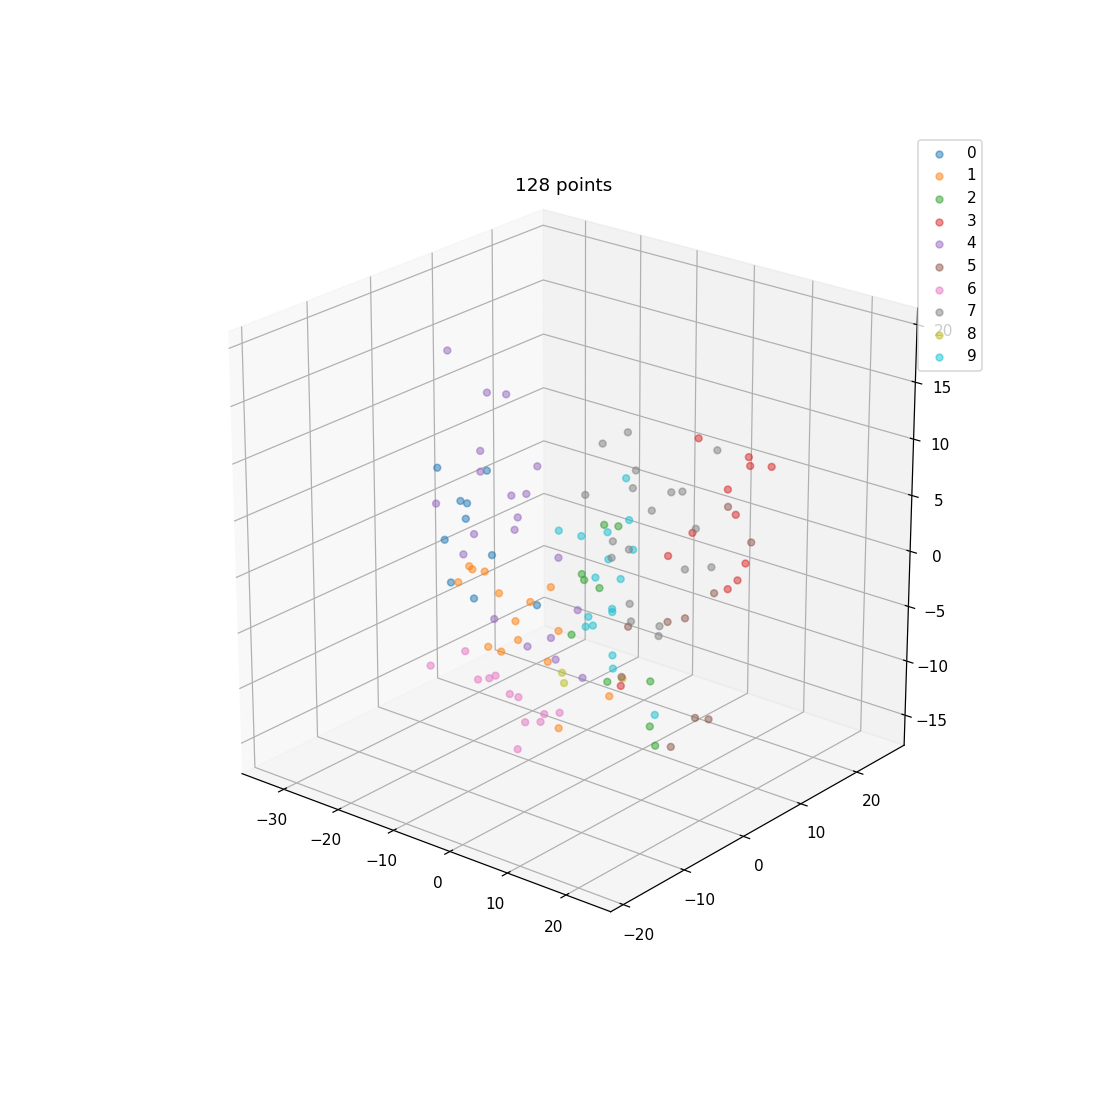

<IPython.core.display.Javascript object>


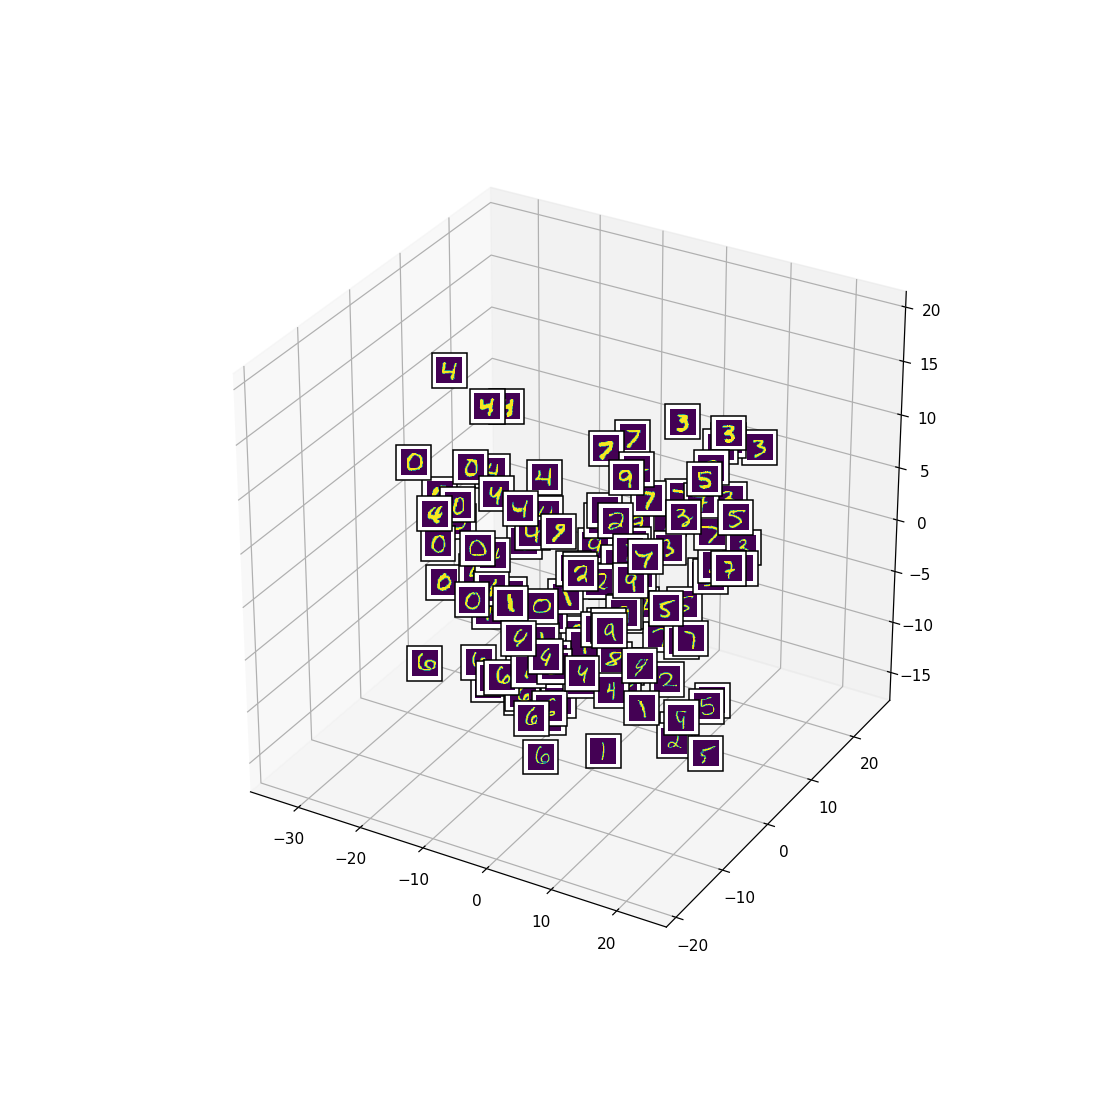

In [31]:
plt.rcParams['figure.figsize'] = [10, 10]

module_pca3d = ModulePCA(learn.model, learn.model[3][0], learn.data.valid_dl)
module_pca3d(k=3, n_batches=1)
module_pca3d.plot3d()
module_pca3d.annotate(zoom=0.6)

## 2D

<IPython.core.display.Javascript object>


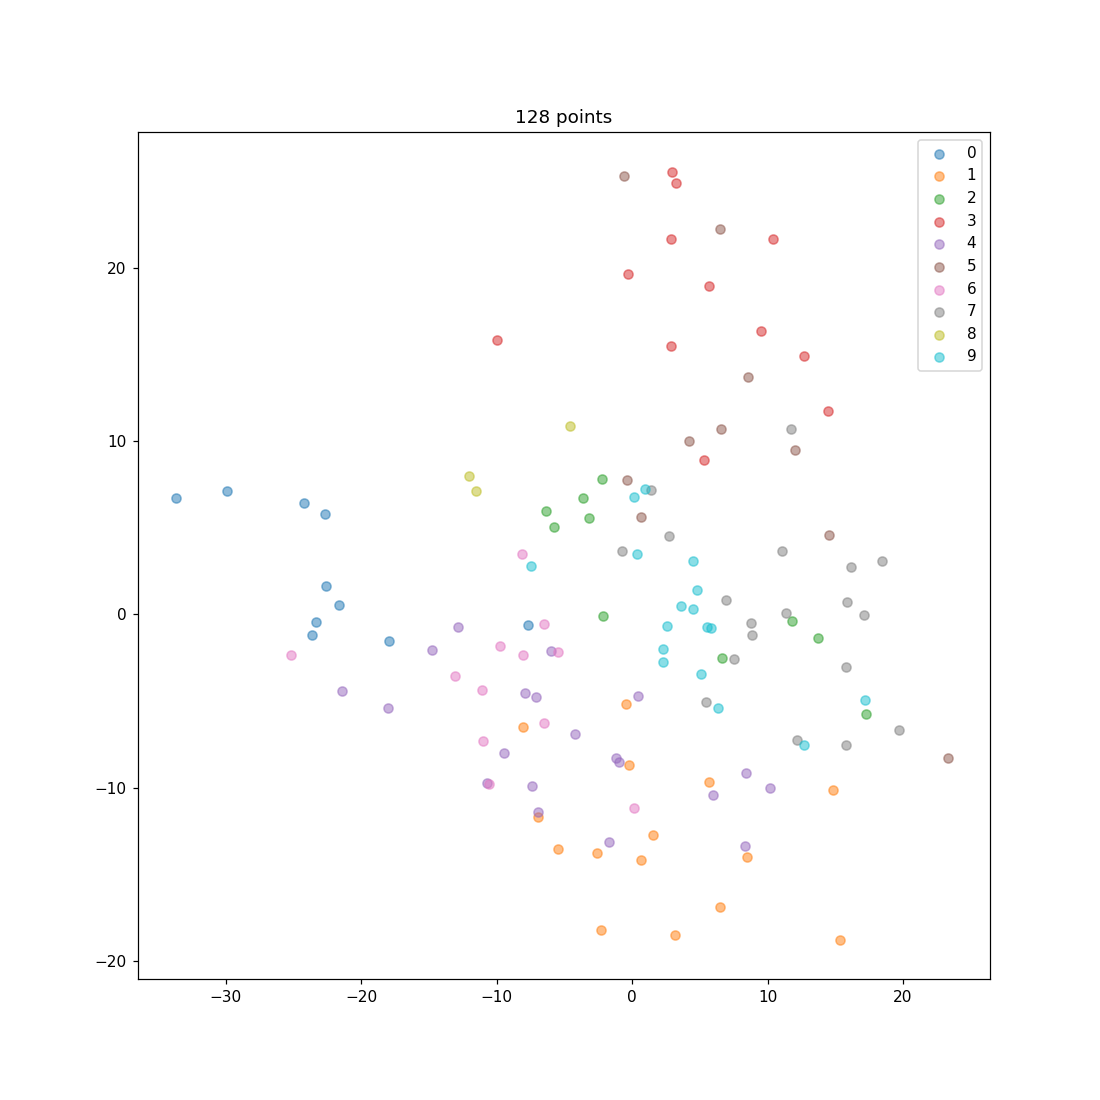

<IPython.core.display.Javascript object>


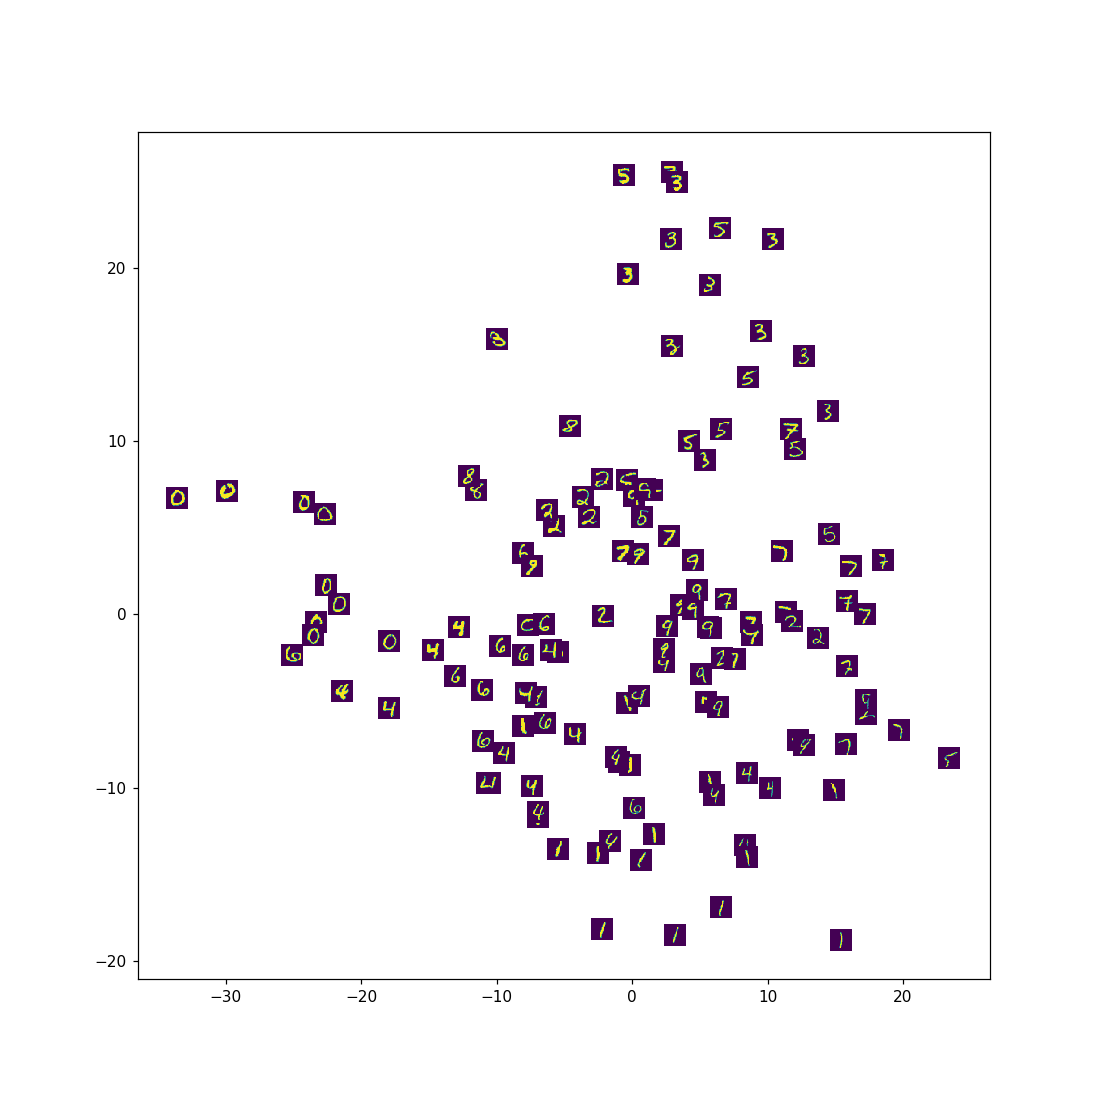

In [30]:
plt.rcParams['figure.figsize'] = [10, 10]
module_pca = ModulePCA(learn.model, learn.model[3][0], learn.data.valid_dl)
module_pca(k=2, n_batches=1)
module_pca.plot2d()
module_pca.annotate(zoom=0.5)